In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm.auto import tqdm, trange
import math

import gymnasium as gym

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create datasets

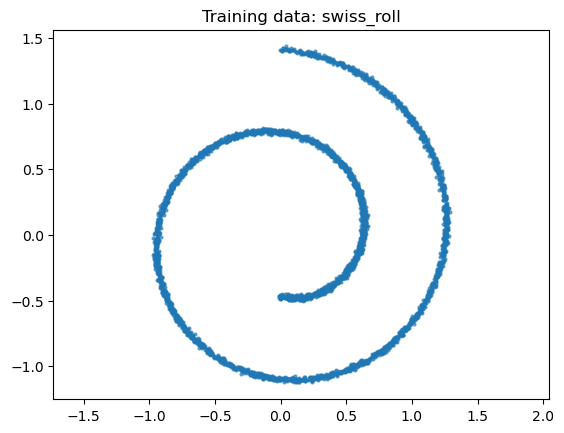

In [3]:
DATASET = "swiss_roll"  # swiss_roll | two_moons
N_SAMPLES = 4096
if DATASET == "swiss_roll":
    data, _ = make_swiss_roll(n_samples=N_SAMPLES, noise=0.1)
    data = data[:, [0, 2]] / 10.0
elif DATASET == "two_moons":
    from sklearn.datasets import make_moons
    data, _ = make_moons(n_samples=N_SAMPLES, noise=0.04)
    data = data * 1.5
else:
    raise ValueError("Unknown DATASET")
dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=512, shuffle=True, drop_last=True)
plt.scatter(data[:, 0], data[:, 1], s=4, alpha=0.6)
plt.title(f"Training data: {DATASET}")
plt.axis("equal")
plt.show()


In [5]:
# --- diffusion schedule ---
T = 1000
beta = torch.linspace(1e-4, 0.02, T, device=device)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
alpha_bar_prev = torch.cat([torch.ones(1, device=device), alpha_bar[:-1]], dim=0)
posterior_var = beta * (1 - alpha_bar_prev) / (1 - alpha_bar)
posterior_var.clamp_(min=1e-20)

def sample_timesteps(batch_size):
    return torch.randint(0, T, (batch_size,), device=device)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alpha_bar = alpha_bar[t].sqrt().unsqueeze(1)
    sqrt_one_minus = (1 - alpha_bar[t]).sqrt().unsqueeze(1)
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise, noise


In [6]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freq = torch.exp(
            torch.arange(half, device=device) * -(math.log(10000) / (half - 1))
        )
        args = t[:, None] * freq[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        h = self.linear1(self.norm1(x))
        h = F.silu(h)
        h = self.linear2(self.norm2(h))
        return x + h

class DiffusionMLP(nn.Module):
    def __init__(self, data_dim=2, hidden_dim=512, time_dim=256, depth=6):
        super().__init__()
        self.time_embed = nn.Sequential(
            TimeEmbedding(time_dim),
            nn.Linear(time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.input_layer = nn.Linear(data_dim + hidden_dim, hidden_dim)
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(depth)])
        self.output = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, data_dim),
        )

    def forward(self, x, t):
        t_emb = self.time_embed(t)
        h = torch.cat([x, t_emb], dim=-1)
        h = self.input_layer(h)
        for block in self.blocks:
            h = block(h)
        return self.output(h)


  0%|          | 0/600 [00:00<?, ?it/s]

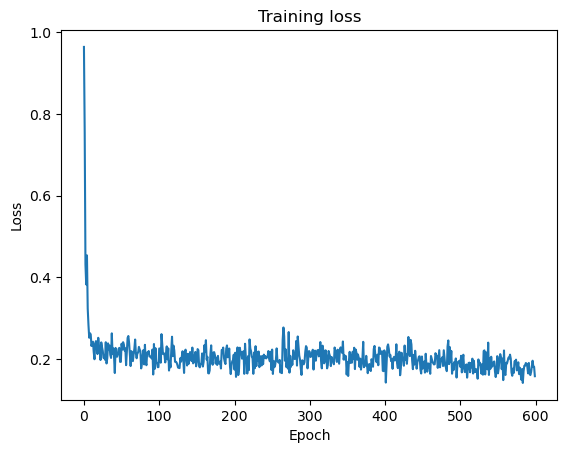

In [6]:
# --- training ---
model = DiffusionMLP().to(device)
ema_model = DiffusionMLP().to(device)
ema_model.load_state_dict(model.state_dict())
def update_ema(ema, src, decay=0.995):
    with torch.no_grad():
        for (k, v_src) in src.state_dict().items():
            ema.state_dict()[k].mul_(decay).add_(v_src * (1 - decay))

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.99), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
n_epochs = 600
grad_clip = 1.0
loss_history = []

for epoch in trange(n_epochs):
    for (x0,) in loader:
        x0 = x0.to(device)
        t = sample_timesteps(x0.size(0))
        x_noisy, noise = q_sample(x0, t)
        noise_pred = model(x_noisy, t)
        loss = nn.functional.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        update_ema(ema_model, model)
    scheduler.step()
    loss_history.append(loss.item())

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()


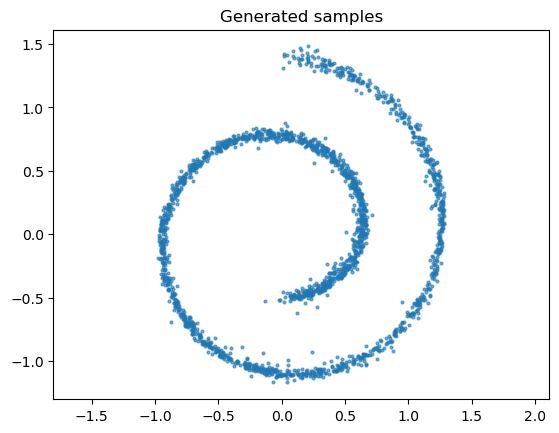

In [7]:
# --- reverse process ---
@torch.no_grad()
def p_sample(model, x, t):
    beta_t = beta[t]
    alpha_t = alpha[t]
    alpha_bar_t = alpha_bar[t]
    alpha_bar_prev_t = alpha_bar_prev[t]
    noise_pred = model(x, torch.full((x.size(0),), t, device=device, dtype=torch.long))
    mean = (1 / alpha_t.sqrt()) * (x - beta_t / (1 - alpha_bar_t).sqrt() * noise_pred)
    if t == 0:
        return mean
    sigma_t = posterior_var[t].sqrt()
    return mean + sigma_t * torch.randn_like(x)

@torch.no_grad()
def sample(model, n_samples=2048):
    model.eval()
    x = torch.randn(n_samples, 2, device=device)
    for t in range(T - 1, -1, -1):
        x = p_sample(model, x, t)
    return x.cpu().numpy()

generated = sample(ema_model, 2000)
plt.scatter(generated[:, 0], generated[:, 1], s=4, alpha=0.6)
plt.title("Generated samples")
plt.axis("equal")
plt.show()


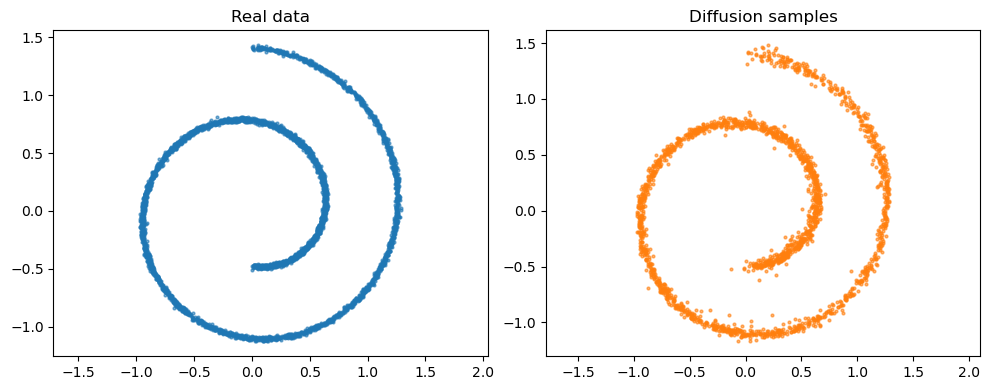

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(data[:, 0], data[:, 1], s=4, alpha=0.6, color="tab:blue")
axes[0].set_title("Real data")
axes[0].axis("equal")

axes[1].scatter(generated[:, 0], generated[:, 1], s=4, alpha=0.6, color="tab:orange")
axes[1].set_title("Diffusion samples")
axes[1].axis("equal")

plt.tight_layout()
plt.show()


# new datsets

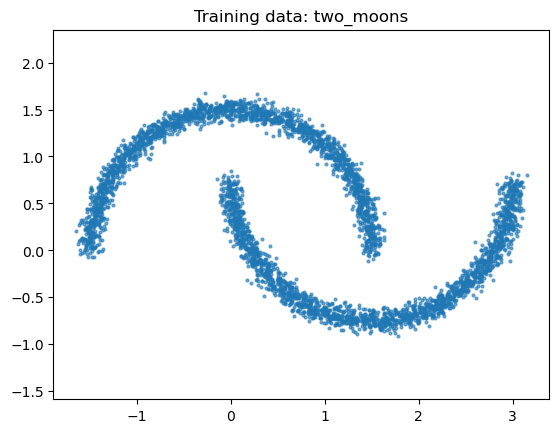

In [9]:
DATASET = "two_moons"  # swiss_roll | two_moons
N_SAMPLES = 4096
if DATASET == "swiss_roll":
    data, _ = make_swiss_roll(n_samples=N_SAMPLES, noise=0.1)
    data = data[:, [0, 2]] / 10.0
elif DATASET == "two_moons":
    from sklearn.datasets import make_moons
    data, _ = make_moons(n_samples=N_SAMPLES, noise=0.04)
    data = data * 1.5
else:
    raise ValueError("Unknown DATASET")
dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=512, shuffle=True, drop_last=True)
plt.scatter(data[:, 0], data[:, 1], s=4, alpha=0.6)
plt.title(f"Training data: {DATASET}")
plt.axis("equal")
plt.show()


  0%|          | 0/600 [00:00<?, ?it/s]

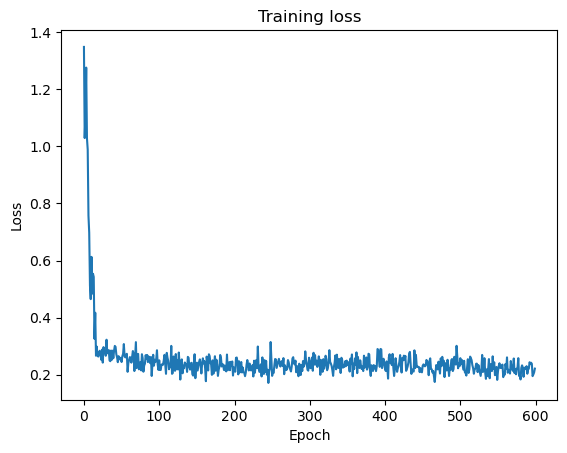

In [10]:
# --- training ---
model = DiffusionMLP().to(device)
ema_model = DiffusionMLP().to(device)
ema_model.load_state_dict(model.state_dict())
def update_ema(ema, src, decay=0.995):
    with torch.no_grad():
        for (k, v_src) in src.state_dict().items():
            ema.state_dict()[k].mul_(decay).add_(v_src * (1 - decay))

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.99), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
n_epochs = 600
grad_clip = 1.0
loss_history = []

for epoch in trange(n_epochs):
    for (x0,) in loader:
        x0 = x0.to(device)
        t = sample_timesteps(x0.size(0))
        x_noisy, noise = q_sample(x0, t)
        noise_pred = model(x_noisy, t)
        loss = nn.functional.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        update_ema(ema_model, model)
    scheduler.step()
    loss_history.append(loss.item())

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()


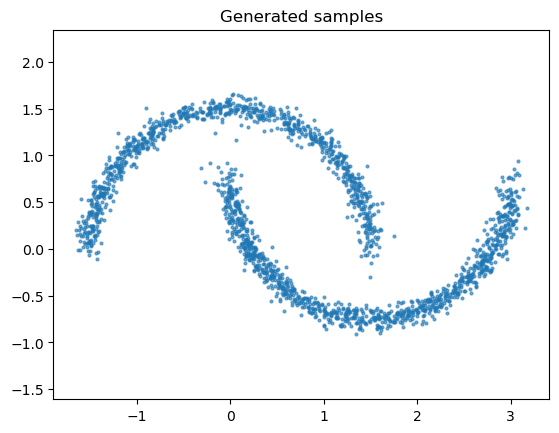

In [11]:
# --- reverse process ---
@torch.no_grad()
def p_sample(model, x, t):
    beta_t = beta[t]
    alpha_t = alpha[t]
    alpha_bar_t = alpha_bar[t]
    alpha_bar_prev_t = alpha_bar_prev[t]
    noise_pred = model(x, torch.full((x.size(0),), t, device=device, dtype=torch.long))
    mean = (1 / alpha_t.sqrt()) * (x - beta_t / (1 - alpha_bar_t).sqrt() * noise_pred)
    if t == 0:
        return mean
    sigma_t = posterior_var[t].sqrt()
    return mean + sigma_t * torch.randn_like(x)

@torch.no_grad()
def sample(model, n_samples=2048):
    model.eval()
    x = torch.randn(n_samples, 2, device=device)
    for t in range(T - 1, -1, -1):
        x = p_sample(model, x, t)
    return x.cpu().numpy()

generated = sample(ema_model, 2000)
plt.scatter(generated[:, 0], generated[:, 1], s=4, alpha=0.6)
plt.title("Generated samples")
plt.axis("equal")
plt.show()


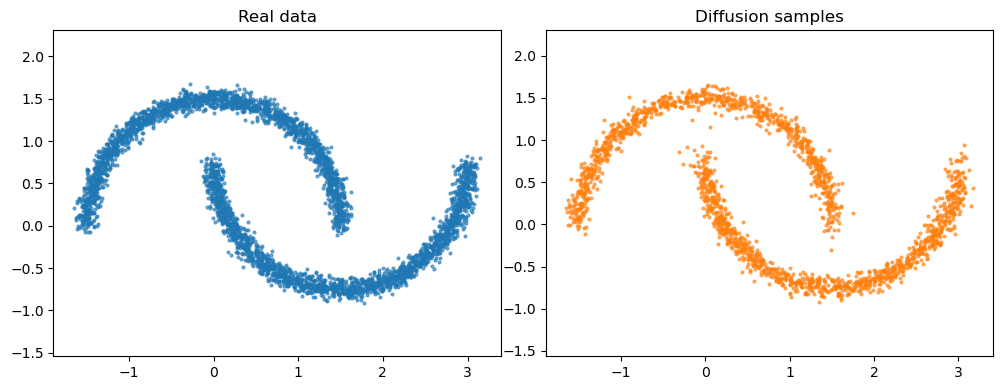

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(data[:, 0], data[:, 1], s=4, alpha=0.6, color="tab:blue")
axes[0].set_title("Real data")
axes[0].axis("equal")

axes[1].scatter(generated[:, 0], generated[:, 1], s=4, alpha=0.6, color="tab:orange")
axes[1].set_title("Diffusion samples")
axes[1].axis("equal")

plt.tight_layout()
plt.show()


# BASIC FLOW MATCHING MODELS

  0%|          | 0/500 [00:00<?, ?it/s]

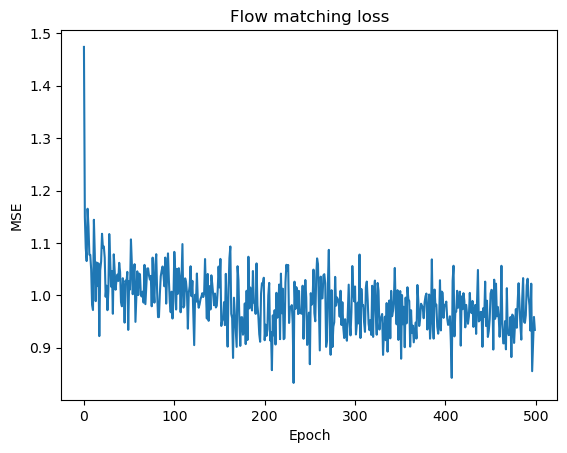

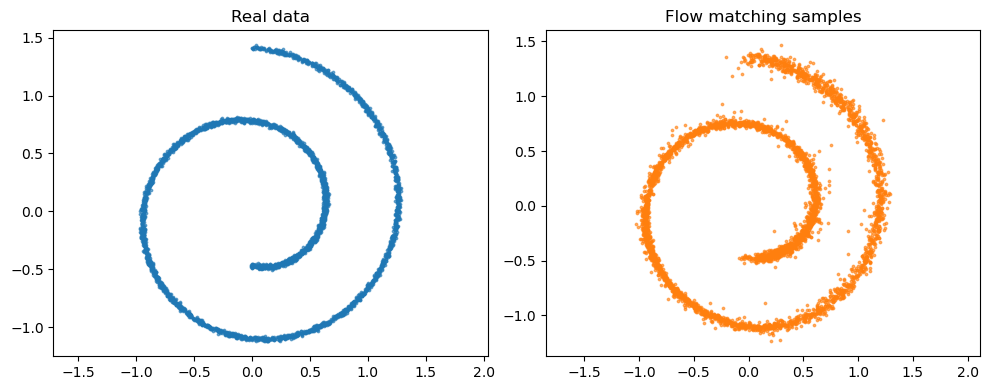

In [11]:
class FlowResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim * 4)
        self.fc2 = nn.Linear(dim * 4, dim)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        h = F.silu(self.fc1(self.norm1(x)))
        h = self.fc2(self.norm2(h))
        return x + h

class FlowMLP(nn.Module):
    def __init__(self, data_dim=2, hidden_dim=512, time_dim=256, depth=6):
        super().__init__()
        self.time_embed = nn.Sequential(
            TimeEmbedding(time_dim),
            nn.Linear(time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.input = nn.Linear(data_dim + hidden_dim, hidden_dim)
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(depth)])
        self.out = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, data_dim),
        )

    def forward(self, x, t):
        t_emb = self.time_embed(t.float())
        h = torch.cat([x, t_emb], dim=-1)
        h = self.input(h)
        for block in self.blocks:
            h = block(h)
        return self.out(h)

def sample_times(batch):
    return torch.rand(batch, device=device)

def interpolate(x0, x1, t):
    return (1.0 - t[:, None]) * x0 + t[:, None] * x1

flow_model = FlowMLP().to(device)
flow_opt = torch.optim.AdamW(flow_model.parameters(), lr=2e-4, weight_decay=1e-4)
flow_epochs = 500
grad_clip = 1.0
flow_losses = []
base = torch.distributions.Normal(torch.zeros(2, device=device), torch.ones(2, device=device))

for epoch in trange(flow_epochs):
    for (x1,) in loader:
        x1 = x1.to(device)
        x0 = base.sample((x1.size(0),))
        t = sample_times(x1.size(0))
        xt = interpolate(x0, x1, t)
        target = x1 - x0
        pred = flow_model(xt, t * (T - 1))
        loss = ((pred - target) ** 2).mean()

        flow_opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(flow_model.parameters(), grad_clip)
        flow_opt.step()
    flow_losses.append(loss.item())

plt.figure()
plt.plot(flow_losses)
plt.title("Flow matching loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

@torch.no_grad()
def flow_sample(model, n_samples=4000, n_steps=300):
    x = base.sample((n_samples,))
    model.eval()
    for i in range(n_steps):
        t = torch.full((n_samples,), (i + 0.5) / n_steps, device=device)
        drift = model(x, t * (T - 1))
        x = x + drift * (1.0 / n_steps)
    return x.cpu().numpy()

flow_generated = flow_sample(flow_model)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], s=3, alpha=0.6)
plt.title("Real data")
plt.axis("equal")
plt.subplot(1, 2, 2)
plt.scatter(flow_generated[:, 0], flow_generated[:, 1], s=3, alpha=0.6, color="tab:orange")
plt.title("Flow matching samples")
plt.axis("equal")
plt.tight_layout()
plt.show()